# Nowcasting Global Surface Irradiance and Cloud Optical Depth with 3D U-Net

This notebook develops and tests a 3D U-Net model for nowcasting Cloud Optical Depth and Surface Irradiance over the Darwin region using Himawari-8 satellite data.
The model takes 7 past timesteps (every 10 minutes) as input and predicts 3 future lead times at +1 h, +2 h, and +3 h.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import datetime
from datetime import timedelta

import numpy as np
import xarray as xr
xr.set_options(file_cache_maxsize=2)

import matplotlib.pyplot as plt

In [3]:
import pyearthtools.data as petdata
from pyearthtools.data.time import TimeResolution, Petdt

import pyearthtools.pipeline as petpipe
from pyearthtools.pipeline.operation import Operation

import pyearthtools.data.indexes._indexes as idx
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=idx.IndexWarning, message="Data requested at a higher resolution")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="NetCDF: HDF error")

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, IterableDataset

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

import torchmetrics.image

In [5]:
torch.manual_seed(42)                                      
torch.set_float32_matmul_precision('medium')             
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
import site_archive_jasmin as saj                  
print(saj.ROOT_DIRECTORIES)

ROOT_DIRECTORIES: {'ERA5lowres': '/gws/ssde/j25a/mmh_storage/theme3/weatherbench/5.625deg/', 'MOGLOBAL': '/gws/ssde/j25a/mmh_storage/theme3/mo_pet_site_archive/mo_global/', 'MOUKV': '/gws/ssde/j25a/mmh_storage/theme3/mo_pet_site_archive/mo_ukv/', 'Himawari': '/gws/ssde/j25a/mmh_storage/theme3/rv74_himawari', 'HimawariChannels': '/gws/ssde/j25a/mmh_storage/theme3/ra22_himawari', 'Rainfields3': '/gws/ssde/j25a/mmh_storage/theme3/rq0_rainfields_prcp_crate'}
{'ERA5lowres': '/gws/ssde/j25a/mmh_storage/theme3/weatherbench/5.625deg/', 'MOGLOBAL': '/gws/ssde/j25a/mmh_storage/theme3/mo_pet_site_archive/mo_global/', 'MOUKV': '/gws/ssde/j25a/mmh_storage/theme3/mo_pet_site_archive/mo_ukv/', 'Himawari': '/gws/ssde/j25a/mmh_storage/theme3/rv74_himawari', 'HimawariChannels': '/gws/ssde/j25a/mmh_storage/theme3/ra22_himawari', 'Rainfields3': '/gws/ssde/j25a/mmh_storage/theme3/rq0_rainfields_prcp_crate'}


# Loading data and choosing variables

Data spans from Jan 2019 to Oct 2024

In [7]:
vars_to_load = ["surface_global_irradiance", "cloud_optical_depth"]
himawari = petdata.archive.Himawari(vars_to_load)

In [8]:
himawari

Himawari
	Description                    Himawari 8/9 satellite data
		 Range                          '2019-current'
		 Resolution                     '10 minutes'


	Initialisation                 
		 data_interval                  (10, 'm')
		 file_regex                     '*{date_info}*{time_info}*.nc'
		 variables                      ['surface_global_irradiance', 'cloud_optical_depth']
	Transforms                     
		 StandardCoordinateNames        {'latitude': "['lat', 'Latitude', 'yt_ocean', 'yt']", 'longitude': "['lon', 'Longitude', 'xt_ocean', 'xt']", 'replacement_dictionary': 'None', 'time': "['Time']"}
		 Trim                           {'__args': '()', 'variables': "['surface_global_irradiance', 'cloud_optical_depth']"}

In [9]:
himawari["20210607T1930"]

<xarray.Dataset> Size: 61MB
Dimensions:                    (time: 1, latitude: 1726, longitude: 2214)
Coordinates:
  * time                       (time) datetime64[ns] 8B 2021-06-07T19:30:00
  * latitude                   (latitude) float32 7kB -44.5 -44.48 ... -10.0
  * longitude                  (longitude) float32 9kB 112.0 112.0 ... 156.3
Data variables:
    cloud_optical_depth        (time, latitude, longitude) float64 31MB dask.array<chunksize=(1, 1726, 2214), meta=np.ndarray>
    surface_global_irradiance  (time, latitude, longitude) float64 31MB dask.array<chunksize=(1, 1726, 2214), meta=np.ndarray>
Attributes: (12/58)
    Conventions:                      CF-1.7
    Metadata_Conventions:             Unidata Dataset Discovery v1.0
    acknowledgment:                   The following acknowledgement is requir...
    cdm_data_type:                    grid
    comment:                          Solar radiation data derived from satel...
    contributor_name:                 Mines ParisTech; Commonwealth of Austra...
    ...                               ...
    quality:                          0
    quality_meaning:                  0: no_known_issues 1: known_issue 
    project:                          Gridded Solar Observations
    history:                          Mon Mar  4 01:55:54 2024: ncatted -a re...
    references:                       Poulsen C., Majewski L. J. (2022) Gridd...
    NCO:                              netCDF Operators version 4.7.7 (Homepag...

# Create a PET Pipeline to prepare dataset for training

## This function is to make sure to use new indices for merging

In [10]:
def proper_temporal_merge(samples):
    valid = []
    for i, s in enumerate(samples):
        if s is not None:
            s = s.copy(deep=True)
            s = s.assign_coords(time=[s.time.values[0] + np.timedelta64(i*10, "m")])
            valid.append(s)
    return xr.concat(valid, dim="time", combine_attrs="override")

## Per-Channel Scaling

In [11]:
class PerChannelScale(Operation):
    def __init__(self, scale_dict):
        """
        scale_dict: dict mapping variable name to scaling factor
        e.g. {"surface_global_irradiance": 1200, "cloud_optical_depth": 60}
        """
        super().__init__(operation="apply")
        self.scale_dict = scale_dict

    def apply_func(self, sample):
        # If TemporalRetrieval returns a tuple, process each element recursively
        if isinstance(sample, tuple):
            return tuple(self.apply_func(s) for s in sample)

        # Normal case: single xarray.Dataset
        ds = sample.copy()
        for var, factor in self.scale_dict.items():
            if var in ds:
                ds[var] = ds[var] / float(factor)
        return ds

# Training data pipeline

In [12]:
scales = {
    "surface_global_irradiance": 1200,   # W/m²
    "cloud_optical_depth": 60            # unitless
}

In [13]:
def make_pipeline(start_time, end_time, region=(-15.5, -8, 130, 135.5)):

    himawari.data_resolution = TimeResolution("minute")
    himawari.data_resolution.value = 10
    
    return petpipe.Pipeline(
        himawari,
        petpipe.operations.xarray.Sort(order=["time", "latitude", "longitude"]),
        petpipe.operations.xarray.AlignDataVariableDimensionsToDatasetCoords(),

        # Temporal window: 7 past frames (t−6 to t₀, every 10 min) and 3 future frames (+1h, +2h, +3h)
        petpipe.modifications.TemporalWindow(
            prior_indexes=[-6, -5, -4, -3, -2, -1, 0],
            posterior_indexes=[6, 12, 18],
            timedelta=timedelta(minutes=10),
            merge_method=proper_temporal_merge
        ),

        petdata.transform.region.Bounding(*region),
        PerChannelScale(scales),
        petpipe.operations.xarray.conversion.ToNumpy(),
        petpipe.operations.numpy.reshape.Rearrange("t c h w -> c t h w"),

        iterator=petpipe.iterators.DateRange(
            start_time,
            end_time,
            interval="10 minutes"
        ),

        exceptions_to_ignore=(petdata.exceptions.DataNotFoundError, ValueError),
    )


In [14]:
trainpipe = make_pipeline("20210601T0000", "20210701T0000")

# Choosing a sample from the pipeline and plotting them for visual check

Input should be: 7 time steps, 2 channels and 276x276 ($t_0$ gping back to $t_0 - 1$h) with a time step of 10 minutes
Output should be 3 time steps, 2 channels and 276x276 ($t_1$ to $t_3$)

In [15]:
t = Petdt(datetime.datetime(2021, 6, 25, 1, 0))
sample = trainpipe[t]
inputs, outputs = sample

print(inputs.shape, outputs.shape)

(7, 2, 276, 276) (3, 2, 276, 276)



Input sequence (7 timesteps, 2 variables):
  t−6: μ0=0.107, μ1=0.273 | σ0=0.277, σ1=0.104
  t−5: μ0=0.101, μ1=0.291 | σ0=0.240, σ1=0.108
  t−4: μ0=0.099, μ1=0.309 | σ0=0.221, σ1=0.114
  t−3: μ0=0.095, μ1=0.327 | σ0=0.194, σ1=0.120
  t−2: μ0=0.093, μ1=0.344 | σ0=0.184, σ1=0.125
  t−1: μ0=0.090, μ1=0.361 | σ0=0.173, σ1=0.131
  t0: μ0=0.089, μ1=0.377 | σ0=0.165, σ1=0.135

Output sequence (3 timesteps, 2 variables):
  t1: μ0=0.080, μ1=0.451 | σ0=0.147, σ1=0.152
  t2: μ0=0.068, μ1=0.505 | σ0=0.131, σ1=0.165
  t3: μ0=0.071, μ1=0.465 | σ0=0.121, σ1=0.149

Input sequence (7 timesteps, 2 variables):


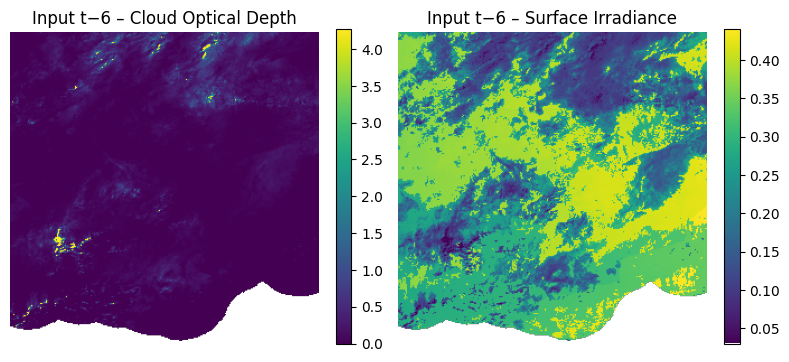

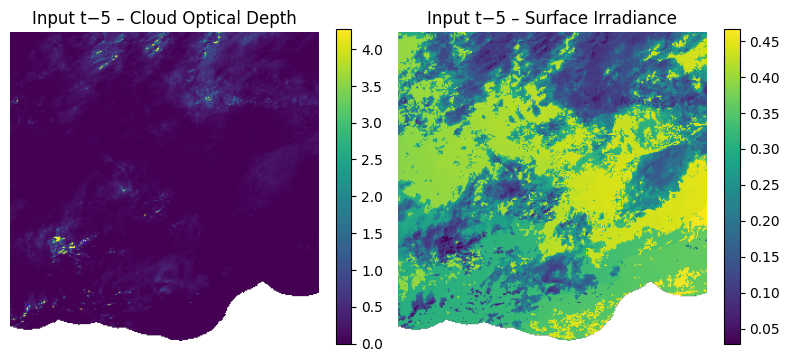

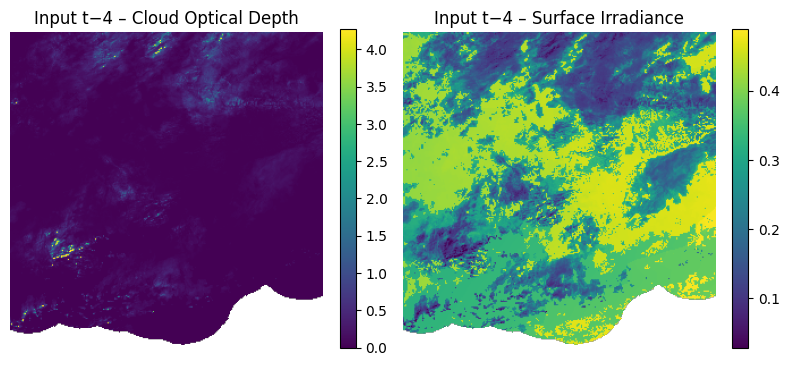

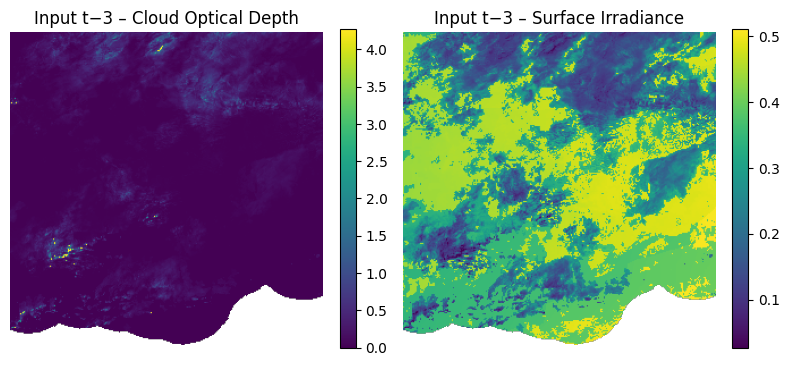

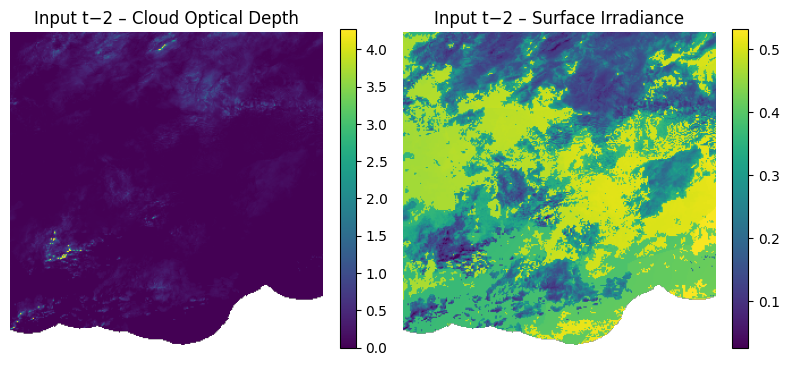

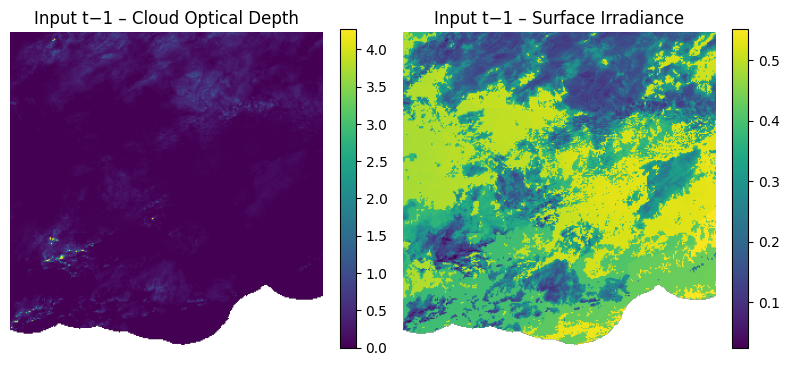

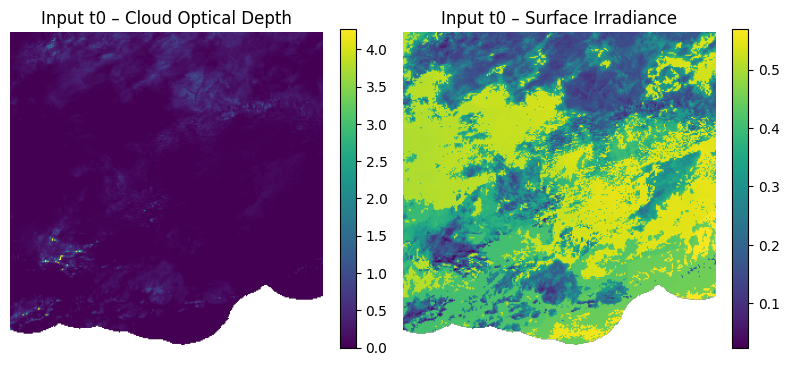


Output sequence (3 timesteps, 2 variables):


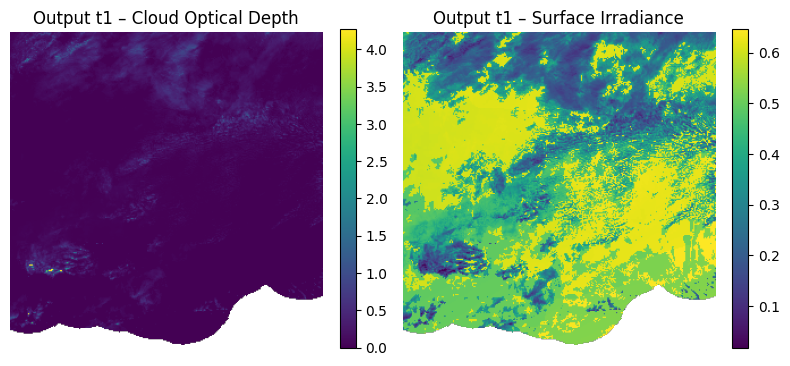

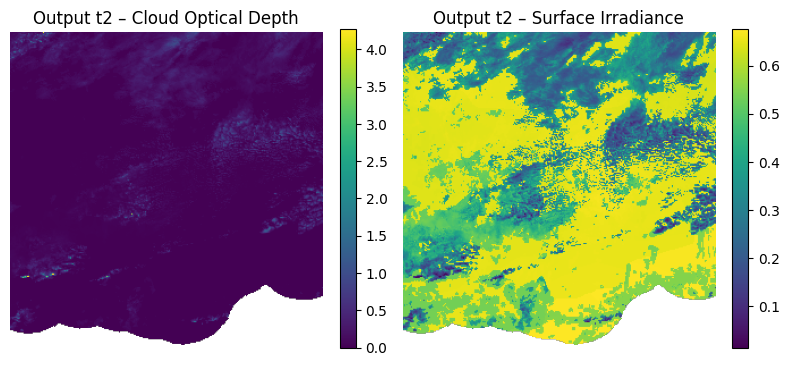

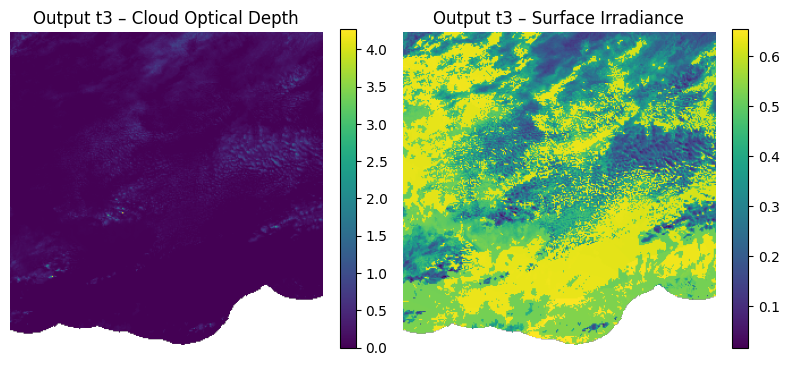

In [16]:
inputs, outputs = sample

def plot_sequence(seq, name, var_names=None, cmap="viridis", t_labels=None):
    n, c, h, w = seq.shape
    var_names = var_names or [f"Var{i}" for i in range(c)]
    if t_labels is None:
        t_labels = [f"t{i}" for i in range(n)]
    print(f"\n{name} sequence ({n} timesteps, {c} variables):")

    for t in range(n):
        fig, axes = plt.subplots(1, c, figsize=(4 * c, 4))
        if c == 1:
            axes = [axes]
        for ch in range(c):
            img = np.where(np.isfinite(seq[t, ch]), seq[t, ch], np.nan)
            ax = axes[ch]
            im = ax.imshow(img, cmap=cmap)
            fig.colorbar(im, ax=ax, fraction=0.046)
            ax.set_title(f"{name} {t_labels[t]} – {var_names[ch]}")
            ax.axis("off")
        plt.tight_layout()
        plt.show()

def describe_sequence(seq, name, t_labels=None):
    n, c, h, w = seq.shape
    if t_labels is None:
        t_labels = [f"t{i}" for i in range(n)]
    print(f"\n{name} sequence ({n} timesteps, {c} variables):")
    for t in range(n):
        means = [float(np.nanmean(seq[t, ch])) for ch in range(c)]
        stds = [float(np.nanstd(seq[t, ch])) for ch in range(c)]
        mean_str = ", ".join([f"μ{ch}={m:.3f}" for ch, m in enumerate(means)])
        std_str = ", ".join([f"σ{ch}={s:.3f}" for ch, s in enumerate(stds)])
        print(f"  {t_labels[t]}: {mean_str} | {std_str}")


# Define custom timestep labels
t_labels_input = [f"t−{i}" for i in range(6, 0, -1)] + ["t0"]  # t−6 … t0
t_labels_output = [f"t{i}" for i in range(1, 4)]               # t1 … t3

# Describe and visualise
describe_sequence(inputs, "Input", t_labels=t_labels_input)
describe_sequence(outputs, "Output", t_labels=t_labels_output)

plot_sequence(inputs, "Input",
              var_names=["Cloud Optical Depth", "Surface Irradiance"],
              t_labels=t_labels_input)

plot_sequence(outputs, "Output",
              var_names=["Cloud Optical Depth", "Surface Irradiance"],
              t_labels=t_labels_output)

# Define model

## Base model

In [17]:
class UNet3D(nn.Module):
    def __init__(self, in_channels=2, out_channels=2, base_filters=32, use_lag=False):
        super().__init__()
        self.use_lag = use_lag

        # ---- Encoder ----
        self.enc1 = self._block(in_channels + (1 if use_lag else 0), base_filters)
        self.enc2 = self._block(base_filters, base_filters * 2)
        self.enc3 = self._block(base_filters * 2, base_filters * 4)
        self.pool = nn.MaxPool3d((1, 2, 2))  # halve spatial dims only

        # ---- Bottleneck ----
        self.bottleneck = self._block(base_filters * 4, base_filters * 8)

        # ---- Decoder ----
        self.up3 = nn.ConvTranspose3d(base_filters * 8, base_filters * 4,
                                      kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.dec3 = self._block(base_filters * 8, base_filters * 4)
        self.up2 = nn.ConvTranspose3d(base_filters * 4, base_filters * 2,
                                      kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.dec2 = self._block(base_filters * 4, base_filters * 2)
        self.up1 = nn.ConvTranspose3d(base_filters * 2, base_filters,
                                      kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.dec1 = self._block(base_filters * 2, base_filters)

        # ---- Temporal projection ----
        self.temporal_head = nn.Sequential(
            nn.Conv3d(base_filters, base_filters, (3, 1, 1), padding=(1, 0, 0)),
            nn.ReLU(inplace=True),
            nn.Conv3d(base_filters, out_channels, (3, 1, 1), padding=(1, 0, 0))
        )

    def _block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv3d(in_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm3d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm3d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, lag=None):
        # Input: (B, 2, T, 276, 276)
        if self.use_lag and lag is not None:
            x = torch.cat([x, lag], dim=1)

        # Downscale to power-of-two size for better performance
        x256 = F.interpolate(x, size=(x.shape[2], 256, 256),
                             mode="trilinear", align_corners=False)

        # Encoder 
        e1 = self.enc1(x256)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b  = self.bottleneck(self.pool(e3))

        # Decoder
        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        # Temporal head 
        out256 = self.temporal_head(d1)        # (B, 2, T, 256, 256)
        out256 = out256[:, :, -3:, :, :]       # keep last 3 future frames

        # Updample back to original 276×276
        out = F.interpolate(out256, size=(out256.shape[2], 276, 276),
                            mode="trilinear", align_corners=False)

        return out

## Custom loss function

The pooled MSE loss compares the **smoothed prediction** $\tilde{\hat{y}}$ and **smoothed target** $\tilde{y}$,  
where both are averaged over a $k \times k$ neighbourhood before computing their mean-squared difference.

$$
\mathcal{L}_{\text{pooled-MSE}}
=
\frac{1}{H\,W}
\sum_{i=1}^{H}
\sum_{j=1}^{W}
\Big(
\tilde{\hat{y}}(i, j)
-
\tilde{y}(i, j)
\Big)^{2}.
$$

This loss encourages the model to match the **spatial structures** of the target field rather than only exact pixel values.

In [18]:
class PooledMSELoss(nn.Module):
    def __init__(self, pool=9):
        super().__init__()
        self.pool = pool

    def forward(self, pred, target):
        # pred, target: (B, C, T, H, W)
        B, C, T, H, W = pred.shape

        # depthwise kernel (one per channel)
        kernel = torch.ones((C, 1, 1, self.pool, self.pool), device=pred.device) / (self.pool ** 2)

        # smooth each channel independently
        pred_smooth = F.conv3d(
            pred, kernel, padding=(0, self.pool // 2, self.pool // 2), groups=C
        )
        target_smooth = F.conv3d(
            target, kernel, padding=(0, self.pool // 2, self.pool // 2), groups=C
        )

        return F.mse_loss(pred_smooth, target_smooth)

## PyTorch lightning wrapper of the model

This class wraps the 3D U-Net model in a PyTorch Lightning module, handling the full training and validation workflow.  
It defines the forward pass, computes the loss, and logs training and validation metrics automatically.  

In [19]:
class NowcastLitModule(pl.LightningModule):
    def __init__(self, lr=1e-4):
        super().__init__()
        self.model = UNet3D()
        self.lr = lr
        self.criterion = PooledMSELoss(pool=9)

    def forward(self, x):
        return self.model(x)
        
    def training_step(self, batch, batch_idx):
        if batch is None:
            return None
        x, y_true = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y_true)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        if batch is None:
            return None
        x, y_true = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y_true)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# Preparing data loader

This dataset wraps the PET pipeline to provide model-ready input–output pairs for PyTorch training.  
Each item retrieves a timestamped sample, converts it to tensors, and replaces missing values with zeros.

In [20]:
class PetNowcastIterableDataset(IterableDataset):
    def __init__(self, pipeline):
        self.pipeline = pipeline

    def __iter__(self):
        it = iter(self.pipeline.iterator)
        for t in it:
            try:
                inputs, outputs = self.pipeline[t]
            except Exception:
                continue
            x = torch.from_numpy(inputs).permute(1, 0, 2, 3).float()
            y = torch.from_numpy(outputs).permute(1, 0, 2, 3).float()
            x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
            y = torch.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)
            yield x, y


# Validation data pipeline

In [21]:
valpipe   = make_pipeline("20210701T0000", "20210708T0000")

In [22]:
train_ds = PetNowcastIterableDataset(trainpipe)
val_ds   = PetNowcastIterableDataset(valpipe)

train_loader = DataLoader(train_ds, batch_size=2, num_workers=0) # keep num_workers=0 to use on jasmin notebook
val_loader   = DataLoader(val_ds, batch_size=2, num_workers=0)

# Train the model

In [23]:
lit_model = NowcastLitModule(lr=1e-4)

checkpoint_cb = ModelCheckpoint(
    dirpath="/home/users/train110/Nowcasting-with-PyEarthTools/model-weights",
    filename="unet3d-nowcast-{epoch:02d}-{val_loss:.4f}",
    monitor="val_loss",
    mode="min",
    save_top_k=1
)

trainer = pl.Trainer(
    max_epochs=1,
    accelerator="gpu",
    devices=1,
    log_every_n_steps=10,
    num_sanity_val_steps=0,
    callbacks=[checkpoint_cb],
    limit_train_batches=500,   # process 500 training batches only (each with 2 samples)
    limit_val_batches=25,  
)

trainer.fit(lit_model, train_loader, val_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type          | Params | Mode 
----------------------------------------------------
0 | model     | UNet3D        | 5.4 M  | train
1 | criterion | PooledMSELoss | 0      | train
----------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.733    Total estimated model params size (MB)
59        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


# Visualise some predictions

In [28]:
testpipe  = make_pipeline("20210708T0000", "20210715T0000")

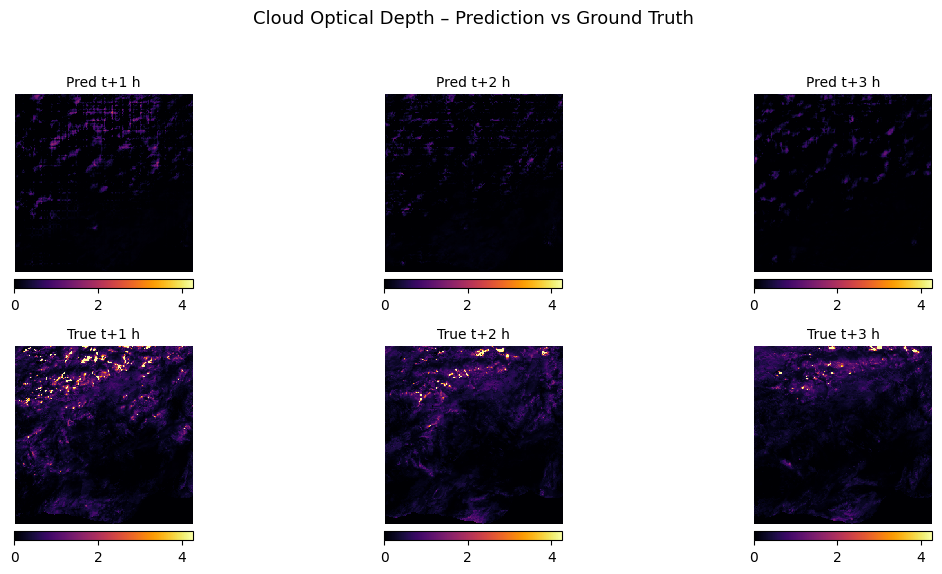

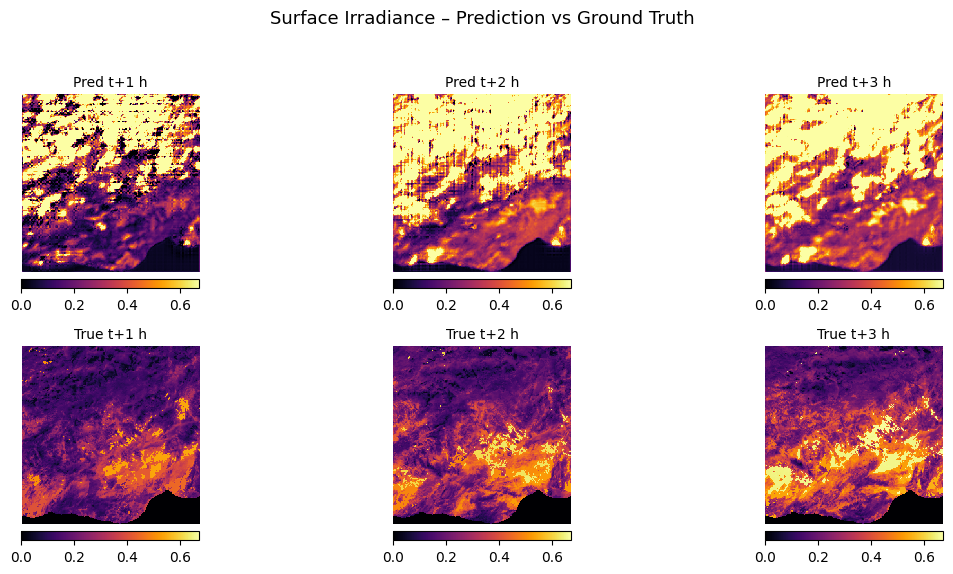

In [29]:
# Inference mode
lit_model.eval()
model = lit_model.model

t = Petdt(datetime.datetime(2022, 7, 1, 0, 0))
inputs, outputs = testpipe[t]

# Move to device
device = next(model.parameters()).device

# Convert to tensors (B, C, T, H, W)
x = torch.from_numpy(inputs).permute(1, 0, 2, 3).unsqueeze(0).float().to(device)
y_true = torch.from_numpy(outputs).permute(1, 0, 2, 3).unsqueeze(0).float().to(device)

# Replace NaNs / infs with 0, make sense given the variables
x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
y_true = torch.nan_to_num(y_true, nan=0.0, posinf=0.0, neginf=0.0)

# Forward pass
with torch.no_grad():
    y_pred = model(x)
    y_pred = y_pred.squeeze(0).cpu().numpy()
    y_true = y_true.squeeze(0).cpu().numpy()

# Plot results
n_channels, n_pred_times = y_pred.shape[:2]
n_true_times = y_true.shape[1]
n_times = min(n_pred_times, n_true_times)
forecast_hours = [1, 2, 3][:n_times]
var_names = ["Cloud Optical Depth", "Surface Irradiance"]

for ch in range(n_channels):
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"{var_names[ch]} – Prediction vs Ground Truth", fontsize=13)

    # to have better visualisation
    vmin = np.nanmin(y_true[ch])
    vmax = np.nanmax(y_true[ch])

    for t_idx in range(n_times):
        # Prediction
        plt.subplot(2, n_times, t_idx + 1)
        im_pred = plt.imshow(
            y_pred[ch, t_idx],
            cmap="inferno",
            interpolation="none",
            vmin=vmin,
            vmax=vmax
        )
        plt.title(f"Pred t+{forecast_hours[t_idx]} h", fontsize=10)
        plt.axis("off")
        plt.colorbar(im_pred, fraction=0.046, pad=0.04, orientation="horizontal")

        # Ground truth
        plt.subplot(2, n_times, n_times + t_idx + 1)
        im_true = plt.imshow(
            y_true[ch, t_idx],
            cmap="inferno",
            interpolation="none",
            vmin=vmin,
            vmax=vmax
        )
        plt.title(f"True t+{forecast_hours[t_idx]} h", fontsize=10)
        plt.axis("off")
        plt.colorbar(im_true, fraction=0.046, pad=0.04, orientation="horizontal")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Evaluation metrics on the test set

In [30]:
ssi_metric = torchmetrics.image.StructuralSimilarityIndexMeasure()
rmse_sw_metric = torchmetrics.image.RootMeanSquaredErrorUsingSlidingWindow()

In [31]:
lit_model.eval()
model = lit_model.model  # actual UNet3D

ssi_values = []
rmse_values = []

test_iterator = iter(testpipe)

with torch.no_grad():
    for i in range(10):  # number of test instances
        inputs, outputs = next(test_iterator)

        device = next(model.parameters()).device

        x = torch.from_numpy(inputs).permute(1, 0, 2, 3).unsqueeze(0).float().to(device)
        y_true = torch.from_numpy(outputs).permute(1, 0, 2, 3).unsqueeze(0).float().to(device)

        # replace NaNs and infinities
        x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        y_true = torch.nan_to_num(y_true, nan=0.0, posinf=0.0, neginf=0.0)

        # forward pass
        y_pred = model(x)

        # move to CPU
        y_pred_cpu = y_pred.squeeze(0).cpu()
        y_true_cpu = y_true.squeeze(0).cpu()

        # compute metrics
        ssi = float(ssi_metric(y_true_cpu, y_pred_cpu))
        rmse = float(rmse_sw_metric(y_true_cpu, y_pred_cpu))

        ssi_values.append(ssi)
        rmse_values.append(rmse)

print("Mean SSI:", np.mean(ssi_values))
print("Mean RMSE:", np.mean(rmse_values))

Mean SSI: 0.3026853233575821
Mean RMSE: 0.1857324242591858


# Next steps

- Train on larger dataset
- Submit jobs to ORCHID
- Parallelise using DDP
- Include PET iterator to PyTorch Dataloader